In [2]:
from manim import *
import jupyter_capture_output

video_scene = " -v WARNING --progress_bar None --disable_caching charge_Scene"
image_scene = f" -v WARNING --progress_bar None --disable_caching -r {2*427},{2*240}  -s charge_Scene"

Manim Community v0.17.3

Jupyter Capture Output v0.0.11


In [12]:
smoothing_factor = 1e-10

# main color of the animation (opposite of the background color)
# main_color = BLACK
# inverted_main_color = WHITE
# red_color = PURE_RED
# blue_color = PURE_BLUE
# grey_color = DARK_GREY

main_color = WHITE
inverted_main_color = BLACK
red_color = RED
blue_color = BLUE
grey_color = GREY

In [95]:
class ElectricField(Mobject):
    def __init__(self, center = np.array([0, 0, 0]), list_of_charges = [(1, np.array([0, 0, 0]))], **kwargs):
        super().__init__(**kwargs)
        self.list_of_charges = list_of_charges

        # coordinate system
        x_range = np.array([-10, 10, 1])
        y_range = np.array([-5, 5, 1])
        x_length = 20
        y_length = 20
        self.x_scale = (x_range[1] - x_range[0]) / x_length
        self.y_scale = (y_range[1] - y_range[0]) / y_length
        self.npla = NumberPlane(
            x_range = x_range, y_range = y_range, x_length = x_length, y_length = y_length,
            x_axis_config = {"stroke_opacity": 0.215, "stroke_color": BLACK}, y_axis_config = {"stroke_opacity": 0.125, "stroke_color": BLACK}, background_line_style = {"stroke_opacity": 0.125}).move_to(center)
        self.add(self.npla)


    # returns list of point charge mobjects
    def get_charge(self, radius = 0.5):
        charge_list = []
        for charge in self.list_of_charges:
            q = charge[0]
            charge_position = charge[1]
            bg_circle = Circle(radius = radius, color = inverted_main_color, stroke_opacity = 0.75, fill_color = inverted_main_color, fill_opacity = 0.75).move_to(self.npla.c2p(*charge_position))
            bg_circle.z_index = 0.5
            if q > 0:   
                charge_circle = Circle(radius = radius, stroke_opacity = 0, fill_color = red_color, fill_opacity = 0.5).move_to(self.npla.c2p(*charge_position))
                charge_text = Text(r"+", weight = BOLD, color = main_color).move_to(self.npla.c2p(*charge_position))
            elif q < 0:
                charge_circle = Circle(radius = radius, stroke_opacity = 0, fill_color = blue_color, fill_opacity = 0.5).move_to(self.npla.c2p(*charge_position))
                charge_text = Text(r"-", weight = BOLD, color = main_color).move_to(self.npla.c2p(*charge_position))
            charge_circle.z_index = 1
            charge_text[0][0].z_index = 2
            single_charge = VGroup(bg_circle, charge_circle, charge_text)   
            charge_list.append(single_charge)
        return charge_list
    

    # returns potential value at 'position'
    def get_potential(self, position):
        x = position[0]
        y = position[1]
        potential = 0
        for charge in self.list_of_charges:
            q = charge[0]
            pos_in_coord = self.npla.c2p(*charge[1])
            x_i = pos_in_coord[0]
            y_i = pos_in_coord[1]
            potential += q / np.sqrt((x-x_i)**2 + (y-y_i)**2 + smoothing_factor)
        return potential
    

    # returns field vector for given position
    def get_vector(self, position):
        x = position[0]
        y = position[1]
        field_vector = 0
        for charge in self.list_of_charges:
            q = charge[0]
            pos_in_coord = self.npla.c2p(*charge[1])
            x_i = pos_in_coord[0]
            y_i = pos_in_coord[1]
            field_vector_length = max([np.sqrt(((x-x_i) * self.x_scale)**2 + ((y-y_i) * self.y_scale)**2 + smoothing_factor), 0.5])
            field_vector += q / field_vector_length**3 * ((x-x_i)*RIGHT + (y-y_i)*UP)
        return field_vector

    
    # returns electric vector field 
    def get_efield(self):
        # function defining the vector field for given 'position'
        field_func = self.get_vector
        return ArrowVectorField(field_func)
    

    # returns electric field as a flow field 
    def get_flowfield(self):
        stream_lines = StreamLines(self.get_vector, stroke_width=3, max_anchors_per_line=30)
        return stream_lines
    

class GaussianVolume(Mobject):
    def __init__(self, center = np.array([0, 0, 0]), radius = 1, x_stretch = 1, y_stretch = 1, rotation = 0, **kwargs):
        super().__init__(**kwargs)
        self.center = center
        self.radius = radius
        self.x_stretch = x_stretch
        self.y_stretch = y_stretch
        self.rotation = rotation

        def gauss_volume_function_intern(phi):
            x = self.radius * self.x_stretch * np.cos(phi) * np.cos(self.rotation) + self.radius * self.y_stretch * np.sin(phi) * np.sin(self.rotation)
            y = self.radius * self.y_stretch * np.sin(phi) * np.cos(self.rotation) - self.radius * self.x_stretch * np.cos(phi) * np.sin(self.rotation)
            return np.array([x, y, 0]) + self.center


        # returns gauss volume
        parametric_function_gauss_volume = ParametricFunction(gauss_volume_function_intern, color = main_color, stroke_opacity = 0.75, stroke_width = 4, t_range = np.array([0, 2*PI, 0.01]))
        self.add(parametric_function_gauss_volume)


    # returns gauss function
    def gauss_volume_function(self, phi):
        x = self.radius * self.x_stretch * np.cos(phi) * np.cos(self.rotation) + self.radius * self.y_stretch * np.sin(phi) * np.sin(self.rotation)
        y = self.radius * self.y_stretch * np.sin(phi) * np.cos(self.rotation) - self.radius * self.x_stretch * np.cos(phi) * np.sin(self.rotation)
        return np.array([x, y, 0]) + self.center
    
    
    # returns vector of the field on the gaussian volumes surface
    def get_gauss_vector(self, vector_field, phi, vector_length = 1):
        vector_position = self.gauss_volume_function(phi)
        vector_direction = vector_field(vector_position)
        vector = Line(start = vector_position - vector_direction/4 * vector_length, end = vector_position + vector_direction/4 * vector_length, color = main_color, stroke_width = 2).add_tip(tip_width = 0.08, tip_length = 0.08)
        return vector
    

    # returns the normal component of the vector on the gaussian volume
    def get_gauss_normal_vector(self, vector_field, phi, vector_length = 1):
        vector_position = self.gauss_volume_function(phi)
        vector_gauss_parallel = self.gauss_volume_function(phi) - self.gauss_volume_function(phi-0.001)
        vector_gauss_normal = np.array([vector_gauss_parallel[1], -vector_gauss_parallel[0], 0]) / np.sqrt(vector_gauss_parallel[0]**2 + vector_gauss_parallel[1]**2 + smoothing_factor)
        vector_direction = vector_field(vector_position)
        normal_length = vector_gauss_normal[0]*vector_direction[0] + vector_gauss_normal[1]*vector_direction[1]
        v_start = vector_position - vector_gauss_normal/4*normal_length * vector_length
        v_end = vector_position + vector_gauss_normal/4*normal_length * vector_length
        vector = Line(start = v_start, end = v_end, color = main_color, stroke_width = 2).add_tip(tip_width = 0.08, tip_length = 0.08)
        return vector
    

class GaussLegend(Mobject):
    def __init__(self, center = np.array([0, 0, 0]), height = 5, width = 4, opacity = 0.75, **kwargs):
        super().__init__(**kwargs)

        legend_bg = Rectangle(height = height, width = width, color = inverted_main_color, stroke_color = inverted_main_color, stroke_opacity = opacity, fill_opacity = opacity).move_to(center)
        legend_bg.z_index = 0.5
        self.add(legend_bg)

        legend_title = MathTex(r"\frac{Q_\mathrm{in}}{\varepsilon_0}=\oint_{\partial V}\Vec{E}\cdot d\Vec{n}", font_size = 36).next_to(legend_bg, UP).shift(1.5*DOWN)
        for i in range(len(legend_title[0])):
            legend_title[0][i].z_index = 4
        self.add(legend_title)


Output saved by overwring previous file at animations/point_charge/point_charge.mp4.


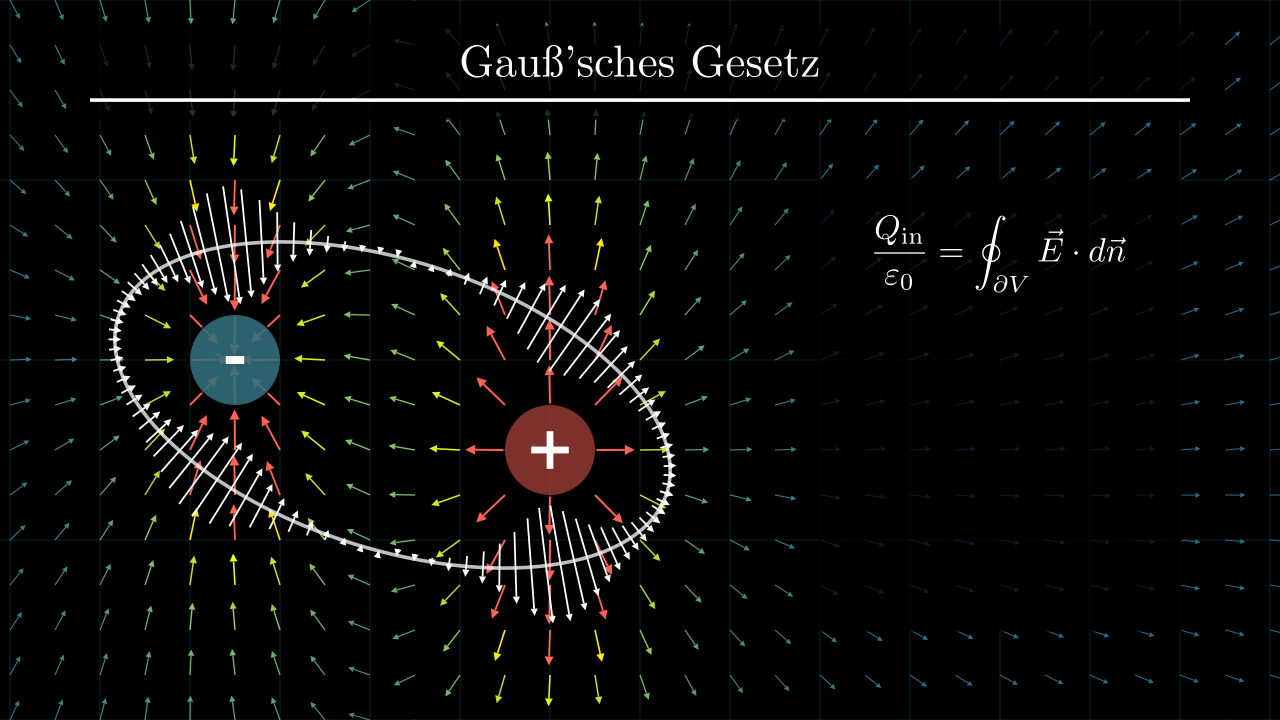

In [96]:
%%capture_video --path "animations/point_charge/point_charge.mp4"
%%manim -qm --fps 60 $video_scene


class charge_Scene(Scene):
    def construct(self):
        self.camera.background_color = inverted_main_color

        # headline
        headline = Title(r"Gauß'sches Gesetz", font_size = 48, color = main_color).align_on_border(UP + LEFT, buff = 0.5).shift(0.5 * RIGHT)
        for i in range(len(headline[0])):
            headline[0][i].z_index = 4
        headline_surrect = SurroundingRectangle(headline, color = inverted_main_color, fill_color = inverted_main_color, stroke_opacity = 0.75, fill_opacity = 0.75, buff = 0.2)
        headline.underline.z_index = 3
        headline_surrect.z_index = 2 
        self.add(headline_surrect, headline)


        # legend
        legend = GaussLegend(center = np.array([4, -0.5, 0]))
        self.add(legend)


        list_of_charges = [
            (-1, np.array([-4.5, 0, 0])),
            (1, np.array([-1, -0.5, 0])),
        ]

        efield = ElectricField(center = np.array([0, 0, 0]), list_of_charges = list_of_charges)
        self.add(efield)

        point_charges = efield.get_charge()
        for charge in point_charges:
            self.add(charge)

        electric_field = efield.get_efield()
        self.add(electric_field)

        gauss_volume = GaussianVolume(center = np.array([-2.75, -0.5, 0]), radius = 0.8, x_stretch = 4, y_stretch = 2, rotation = PI/12 + 0.05)
        self.add(gauss_volume)

        # electric_flowfield = efield.get_flowfield()
        # electric_flowfield.start_animation(warm_up = False, flow_speed = 1.5)

        # self.wait(1.5)
        # self.play(FadeIn(gauss_volume), run_time = 3)
        # self.wait(5)
        # self.play(FadeIn(electric_flowfield), run_time = 3)
        # self.wait(3)
        # self.play(FadeOut(electric_flowfield), run_time = 3)
        # self.wait(3)

        #self.add(electric_flowfield)

        #self.wait(10)

        gauss_vector_group = VGroup()
        gauss_vector_normal_group = VGroup()
        for phi in np.linspace(0, 2*PI, 100):
            gauss_vector = gauss_volume.get_gauss_vector(vector_field = efield.get_vector, phi = phi, vector_length = 0.55)
            gauss_normal_vector = gauss_volume.get_gauss_normal_vector(vector_field = efield.get_vector, phi = phi, vector_length = 0.55)
            gauss_vector_group.add(gauss_vector)
            gauss_vector_normal_group.add(gauss_normal_vector)

        
        self.add(gauss_vector_normal_group)

        # self.wait(1.5)
        # self.play(FadeIn(gauss_vector_group), run_time = 3)
        # self.play(FadeTransform(gauss_vector_group, gauss_vector_normal_group), run_time = 3)
        # self.wait(1.5)
